In [1]:
import sys
sys.path.append('..')
import torch
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, PauliOp, Zero
from qiskit import quantum_info
from qiskit_machine_learning.neural_networks import OpflowQNN

import time

# Related package

import numpy as np
import matplotlib.pyplot as plt

# Hamiltonian related
from openfermion.chem import MolecularData
import openfermion
from openfermionpyscf import run_pyscf

# MISC
r_bohr = 0.529177210903

# Global variable
n_qubits = 4

# 
tolerance = 1e-6
min_pass = 5

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
n_points = 40
bond_length_interval = 3.0 / n_points
# Qiskit instance
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))


In [2]:
def Rot(circ, alpha, beta, theta, qubit):
    circ.rx(alpha, qubit)
    circ.ry(beta, qubit)
    circ.rz(theta, qubit)
# Ansatz
def ansatz(circ, params):
    for i in range(n_qubits):
        print(i)
        Rot(circ, params[i*3+0], params[i*3+1], params[i*3+2], i)
    for j in range(n_qubits-1, -1, -1):
        for k in range(j+1, n_qubits):
            circ.cx(j, k)

In [3]:
# Hamiltonian


def get_H2_hamiltonian(distance):
    bond_length=distance*r_bohr
    geometry = [('H', (0., 0., -bond_length/2)), ('H', (0., 0., bond_length/2))]
    molecule = MolecularData(
        geometry, basis, multiplicity,charge=0,
        description=str(round(bond_length, 2)))
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
    terms_molecular_hamiltonian = molecule.get_molecular_hamiltonian(occupied_indices=[], active_indices=[0,1])
    fermionic_hamiltonian = openfermion.transforms.get_fermion_operator(terms_molecular_hamiltonian)
    jw_hamiltonian = openfermion.transforms.jordan_wigner(fermionic_hamiltonian)
#     print(jw_hamiltonian.terms)
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.fci_energy))

    return jw_hamiltonian.terms, molecule.fci_energy


In [4]:
# parameters
params_list = []
for idx in range(12):
    params_list.append(Parameter("param_"+str(idx)))

In [5]:


def measurements(gatesPrefix):
    obs = list("IIII")
    for qubit, gatePrefix in list(gatesPrefix):
        obs[qubit]=gatePrefix

    return "".join(obs)
def initCircuit(distance):
    H, fci_energy = get_H2_hamiltonian(distance)
    def circuitDefTemplate(params, obsStr):
        ansatz(params)
        return  measurements(obsStr)
    
    qnn_circ = QuantumCircuit(n_qubits, 0)
    ansatz(qnn_circ, params_list)
    
    expval = AerPauliExpectation()
    
    # define gradient method
    gradient = Gradient(grad_method='lin_comb')
#     gradient=[]
    qc_sfn1 = StateFn(qnn_circ)
    weightList = []
    measList = []
    for i, idx in enumerate(H):
        weightList.append(H[idx].real)
        measList.append(measurements(idx))
    H1 = StateFn(PauliSumOp.from_list(list(zip(measList, weightList))))
    op1 = ~H1 @ qc_sfn1
#     qnn = CircuitQNN(circuit=op1, input_params=[], weight_params=qnn_circ.parameters, gradient=gradient, sampling=False, input_gradients=True, quantum_instance=qi, sparse=False)
    qnn = OpflowQNN(op1, [], qnn_circ.parameters, expval, gradient, qi, input_gradients=False)
    initial_weights = torch.ones(12, requires_grad=True)
    model = TorchConnector(qnn, initial_weights, sparse=False)

        
    return model, fci_energy


In [6]:
import torch.nn as nn

distList = np.arange(0.5,1, 0.5)
energyList = np.array([])
fciEnergyList = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)
# params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)

time_start = time.time()


timestamp = np.array([])
error = np.array([])

for distance in distList:
    model, fciE = initCircuit(distance)
#     params = torch.rand(12, requires_grad=True)
#     params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.9)
    
#     print(weightList)
    exp = last_exp = 10000
    count = 0.
    for epoch in range(1000):
        l_sum = 0

        loss = nn.L1Loss()
        exp = model()
        
        
        if epoch%5==0:
            print(epoch, exp.item())
            timestamp = np.append(timestamp, time.time()-time_start)
            error = np.append(error, exp.item()-fciE)
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                timestamp = np.append(timestamp, time.time()-time_start)
                error = np.append(error, exp.item()-fciE)
                break
        else:
            count = 0
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    energyList = np.append(energyList, exp.item())
    fciEnergyList = np.append(fciEnergyList, fciE)
time_end = time.time()

[0.5]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0
1
2
3
0 1.5773617029190063
5 0.8898317813873291
10 0.771217942237854
15 0.6882184743881226
20 0.648809015750885
25 0.6312397122383118
30 0.6234362125396729
35 0.6180472373962402
40 0.6134340167045593
45 0.6113559007644653
50 0.6112740635871887
55 0.6101062893867493
60 0.608771026134491
65 0.6090789437294006
70 0.608794629573822
75 0.6086010932922363
80 0.6086207032203674
85 0.6085271835327148
90 0.6085188984870911
95 0.6085130572319031
100 0.608485996723175
105 0.6084957122802734
110 0.6084859371185303
115 0.6084834337234497
120 0.608485221862793
125 0.6084828972816467
130 0.6084825992584229


time:  45.974221776


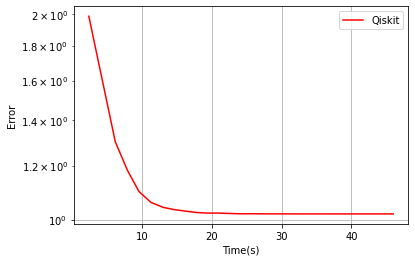

In [7]:
plt.plot(timestamp, error, 'r-', label="Qiskit")
plt.xlabel('Time(s)')
plt.grid()
plt.ylabel('Error')
plt.gca().set_yscale('log')
plt.legend()
print("time: ", time_end-time_start)

In [8]:
import torch.nn as nn

distList = np.arange(0.5,3.5, 0.1)
energyList = np.array([])
fciEnergyList = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)
# params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)

time_start = time.time()


for distance in distList:
    time_epoch_start = time.time()
    model, fciE = initCircuit(distance)
#     params = torch.rand(12, requires_grad=True)
#     params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.9)
    
#     print(weightList)
    exp = last_exp = 10000
    count = 0.
    for epoch in range(1000):
        l_sum = 0

        loss = nn.L1Loss()
        exp = model()
        
        
        if epoch%5==0:
            print(epoch, exp.item())
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                break
        else:
            count = 0
        if time.time()-time_epoch_start>5:
            break
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    energyList = np.append(energyList, exp.item())
    fciEnergyList = np.append(fciEnergyList, fciE)
time_end = time.time()

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0
1
2
3
0 1.5773617029190063
5 0.8898317813873291
Hartree-Fock energy of -0.6682564110880089 Hartree.
Hartree-Fock energy of -0.6765108103840292 Hartree.
0
1
2
3
0 1.1939517259597778
5 0.5784956812858582
Hartree-Fock energy of -0.837130298190518 Hartree.
Hartree-Fock energy of -0.8463259843661401 Hartree.
0
1
2
3
0 0.9087648391723633
5 0.3633112609386444
Hartree-Fock energy of -0.9473079310932639 Hartree.
Hartree-Fock energy of -0.9575985319987075 Hartree.
0
1
2
3
0 0.6876857280731201
5 0.20664110779762268
Hartree-Fock energy of -1.0194970559578667 Hartree.
Hartree-Fock energy of -1.031043026434856 Hartree.
0
1
2
3
0 0.5116649270057678
5 0.08535034954547882
Hartree-Fock energy of -1.065999462131583 Hartree.
Hartree-Fock energy of -1.0789697691855356 Hartree.
0
1

time:  167.981493905


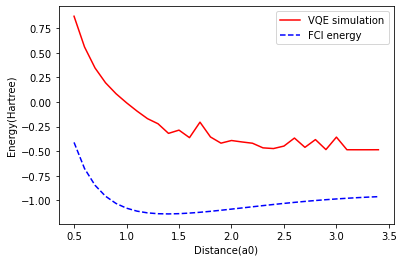

In [9]:
plt.plot(distList, energyList, 'r-', label="VQE simulation")
plt.plot(distList, fciEnergyList, 'b--', label="FCI energy")
plt.xlabel('Distance(a0)')

plt.ylabel('Energy(Hartree)')
plt.legend()
print("time: ", time_end-time_start)

In [10]:
import torch.nn as nn

distList = np.arange(0.5,3.5, 0.1)
energyList_1 = np.array([])
print(distList)
params = torch.ones(12, requires_grad=True)
# params = torch.rand(12, requires_grad=True)
# params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)

time_start = time.time()


for distance in distList:
    time_epoch_start = time.time()
    model, fciE = initCircuit(distance)
#     params = torch.rand(12, requires_grad=True)
#     params = torch.tensor([3.2203e+00, 5.0488e-02, 1.0000e+00, 3.1412e+00, 3.1412e+00, 1.0000e+00, 3.1407e+00, 1.0005e-03, 1.0000e+00, 4.9604e-04, 2.4310e-03, 1.0000e+00],requires_grad=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.9)
    
#     print(weightList)
    exp = last_exp = 10000
    count = 0.
    for epoch in range(1000):
        l_sum = 0

        loss = nn.L1Loss()
        exp = model()
        
        
        if epoch%5==0:
            print(epoch, exp.item())
        if np.abs(exp.item()-last_exp)<tolerance:
            count+=1
            if count>min_pass:
                break
        else:
            count = 0
        if time.time()-time_epoch_start>30:
            break
        last_exp = exp.item()
        l = loss(exp, torch.Tensor([-100.]))
        l.backward()        
        optimizer.step()
        optimizer.zero_grad()
    energyList_1 = np.append(energyList_1, exp.item())
time_end = time.time()

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4]
Hartree-Fock energy of -0.4033264416010218 Hartree.
Hartree-Fock energy of -0.41078847041741406 Hartree.
0
1
2
3
0 1.5773617029190063
5 0.8898317813873291
10 0.771217942237854
15 0.6882184743881226
20 0.648809015750885
25 0.6312397122383118
30 0.6234362125396729
35 0.6180472373962402
40 0.6134340167045593
45 0.6113559007644653
Hartree-Fock energy of -0.6682564110880089 Hartree.
Hartree-Fock energy of -0.6765108103840292 Hartree.
0
1
2
3
0 1.1939517259597778
5 0.5784956812858582
10 0.466538667678833
15 0.38603872060775757
20 0.34862691164016724
25 0.33248740434646606
30 0.3253920376300812
35 0.320214182138443
40 0.31556710600852966
45 0.31327030062675476
50 0.31354808807373047
Hartree-Fock energy of -0.837130298190518 Hartree.
Hartree-Fock energy of -0.8463259843661401 Hartree.
0
1
2
3
0 0.9087648391723633
5 0.3633112609386444
10 0.25840529799461365
15 0.18067736923

0 -0.3352985084056854
5 -0.4984727203845978
10 -0.5068886876106262
15 -0.51160728931427
20 -0.5162514448165894
Hartree-Fock energy of -0.916376819488656 Hartree.
Hartree-Fock energy of -1.001125164194927 Hartree.
0
1
2
3
0 -0.34367087483406067
5 -0.5012959837913513
10 -0.5091851949691772
15 -0.5145811438560486
Hartree-Fock energy of -0.9006035865914606 Hartree.
Hartree-Fock energy of -0.9927661268157253 Hartree.
0
1
2
3
0 -0.3509241044521332
5 -0.5030263066291809
10 -0.5102757215499878
15 -0.5176608562469482
Hartree-Fock energy of -0.8852750001255916 Hartree.
Hartree-Fock energy of -0.985156824374877 Hartree.
0
1
2
3
0 -0.3572028577327728
5 -0.5038195252418518
10 -0.5104280710220337
15 -0.5217369198799133
Hartree-Fock energy of -0.870429788406518 Hartree.
Hartree-Fock energy of -0.9782910065654862 Hartree.
0
1
2
3
0 -0.36263415217399597
5 -0.5040205717086792
10 -0.5099339485168457
15 -0.5262159109115601
20 -0.5264691710472107
Hartree-Fock energy of -0.8560969196807475 Hartree.
Hartree-

In [11]:
np.savez('vqe_qiskit.npz', t=timestamp, e=error, d=distList, el=energyList, el1=energyList_1, rel=fciEnergyList)

##### 